<a href="https://colab.research.google.com/github/Dena7Qatry/Bayesian_Classifier_Scratch_MNIST/blob/main/Lightweight_CNN_for_crop_monitering_vs_pretrained_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Setup & Imports

In [ ]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import plot_model
from tensorflow.keras import optimizers,layers
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense,Dropout,Flatten,BatchNormalization,Conv2D,MaxPooling2D,GlobalAveragePooling2D
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc,classification_report, confusion_matrix
print(tf.__version__)


2.19.0


#2. Data Loading & preprocessing

The [PlantVillage](https://www.kaggle.com/datasets/mohitsingh1804/plantvillage) is used for training and testing the DL models

In [ ]:
# Install pydrive2
!pip install -U -q PyDrive2

# Authenticate and import libraries
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate user
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the file with title 'PlantVillage.zip'
file_list = drive.ListFile({'q': "title='PlantVillage.zip'"}).GetList()
if file_list:
    file_id = file_list[0]['id']
    file = drive.CreateFile({'id': file_id})
    file.GetContentFile('PlantVillage.zip')
    print("Download complete.")
else:
    print("File not found.")

# Unzip the file
!unzip -o 'PlantVillage.zip'

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/val/Soybean___healthy/52c7d07b-561b-4380-801a-3824e65a5135___RS_HL 3797.JPG  
  inflating: PlantVillage/val/Soybean___healthy/53168d1c-ac90-4039-9eff-7479475a6b74___RS_HL 6355.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5344b09f-bbbe-4a2c-9345-d93dd4e69eb4___RS_HL 4693.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5361ba4a-351e-466c-99c5-8845f35c00df___RS_HL 2890.JPG  
  inflating: PlantVillage/val/Soybean___healthy/537e5409-d824-4859-967f-3c502f13deec___RS_HL 5474.JPG  
  inflating: PlantVillage/val/Soybean___healthy/538969da-545b-4bce-bc1d-0932898dc5e6___RS_HL 5230.JPG  
  inflating: PlantVillage/val/Soybean___healthy/538ccfe2-1509-40d7-beae-ae7cf84e1e5d___RS_HL 3717.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5397bf6a-aeeb-4f1c-b554-bdb604bb23c3___RS_HL 6508.JPG  
  inflating: PlantVillage/val/Soybean___healthy/53dc0466-621c-43e1-9c5e-e340f3d50171___RS_HL 6381.JPG  
  inflating: 

In [ ]:
# Creating separate ImageDataGenerators for training and validation
print("="*80)
print("STEP 1: Dataset Preparation (Baseline - No Augmentation)")
print("="*80)

#All images will be resized to 224×224 pixels
image_size = 224
batch_size = 20

# Simple rescaling only - no augmentation for baseline comparison
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.20)
test_datagen = ImageDataGenerator(rescale=1/255)

dataset_train = '/content/PlantVillage/train'

dataset_val = '/content/PlantVillage/val'

train_dataset = train_datagen.flow_from_directory(
    dataset_train,
    shuffle=True,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    subset='training',
    seed=123,
)

validation_dataset = train_datagen.flow_from_directory(
    dataset_val,
    shuffle=False,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    subset='validation',
    seed=123,
)


STEP 1: Dataset Preparation (Baseline - No Augmentation)
Found 34771 images belonging to 38 classes.
Found 2160 images belonging to 38 classes.


#3. EDA: Exploratory Data Analysis

In [ ]:
num_classes = train_dataset.num_classes
class_names = list(train_dataset.class_indices.keys())

print(f"\nDataset Statistics:")
print(f"Number of classes: {num_classes}")
print(f"Training samples: {train_dataset.samples}")
print(f"Validation samples: {validation_dataset.samples}")


Dataset Statistics:
Number of classes: 38
Training samples: 34771
Validation samples: 2160


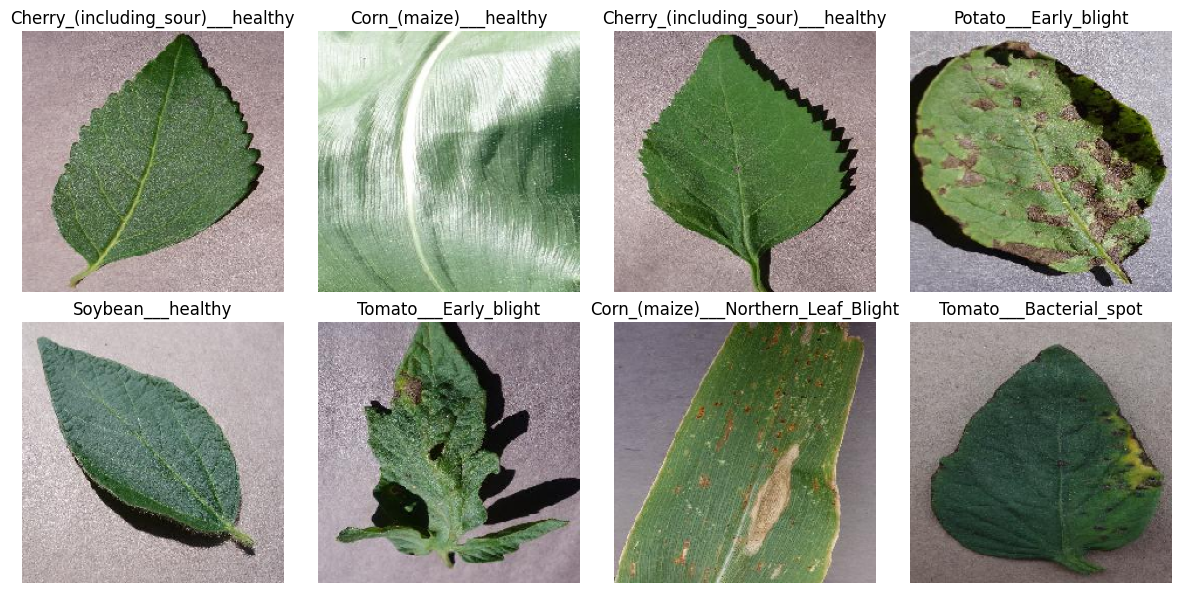

In [ ]:
#Visualizing some images of different Classes
images, labels = next(train_dataset)
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

#4. Models:

##1. Lightweight Compact CNN:

Below is the Architecture of the compact CNN

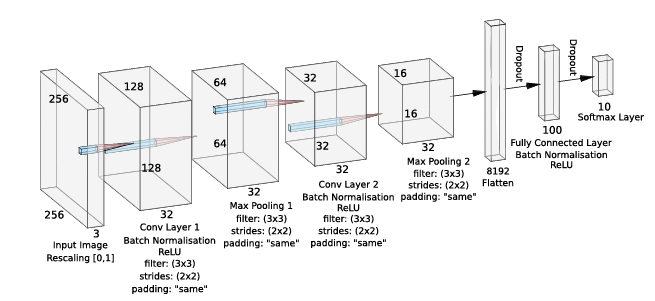

In [ ]:
image_size = 224
input_shape = (image_size,image_size,3)

compact_cnn = Sequential()

compact_cnn.add(Conv2D(filters=32,kernel_size=(3,3),input_shape = input_shape, activation= 'relu',strides=(2,2),padding='same'))
compact_cnn.add(MaxPooling2D(pool_size=(2,2)))

compact_cnn.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=input_shape, activation= 'relu',strides=(2,2),padding='same'))
compact_cnn.add(MaxPooling2D(pool_size=(2,2)))

compact_cnn.add(Flatten())
compact_cnn.add(Dropout(0.5))

compact_cnn.add(Dense(100,activation='relu'))
compact_cnn.add(Dropout(0.5))

compact_cnn.add(Dense(38,activation='softmax'))

#compiling:
compact_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


##2. MobileNetV3-Small
 (Transfer Learning - Frozen Base)

In [ ]:
pre_trained_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
pre_trained_model.trainable = False  # Freeze base for transfer learning

mobilenet_model = Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.Dense(38, activation='softmax')
])

#compiling:
mobilenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


##3. ResNet50
(Transfer Learning - Frozen Base)


### Below is the Architecture of Resnet50
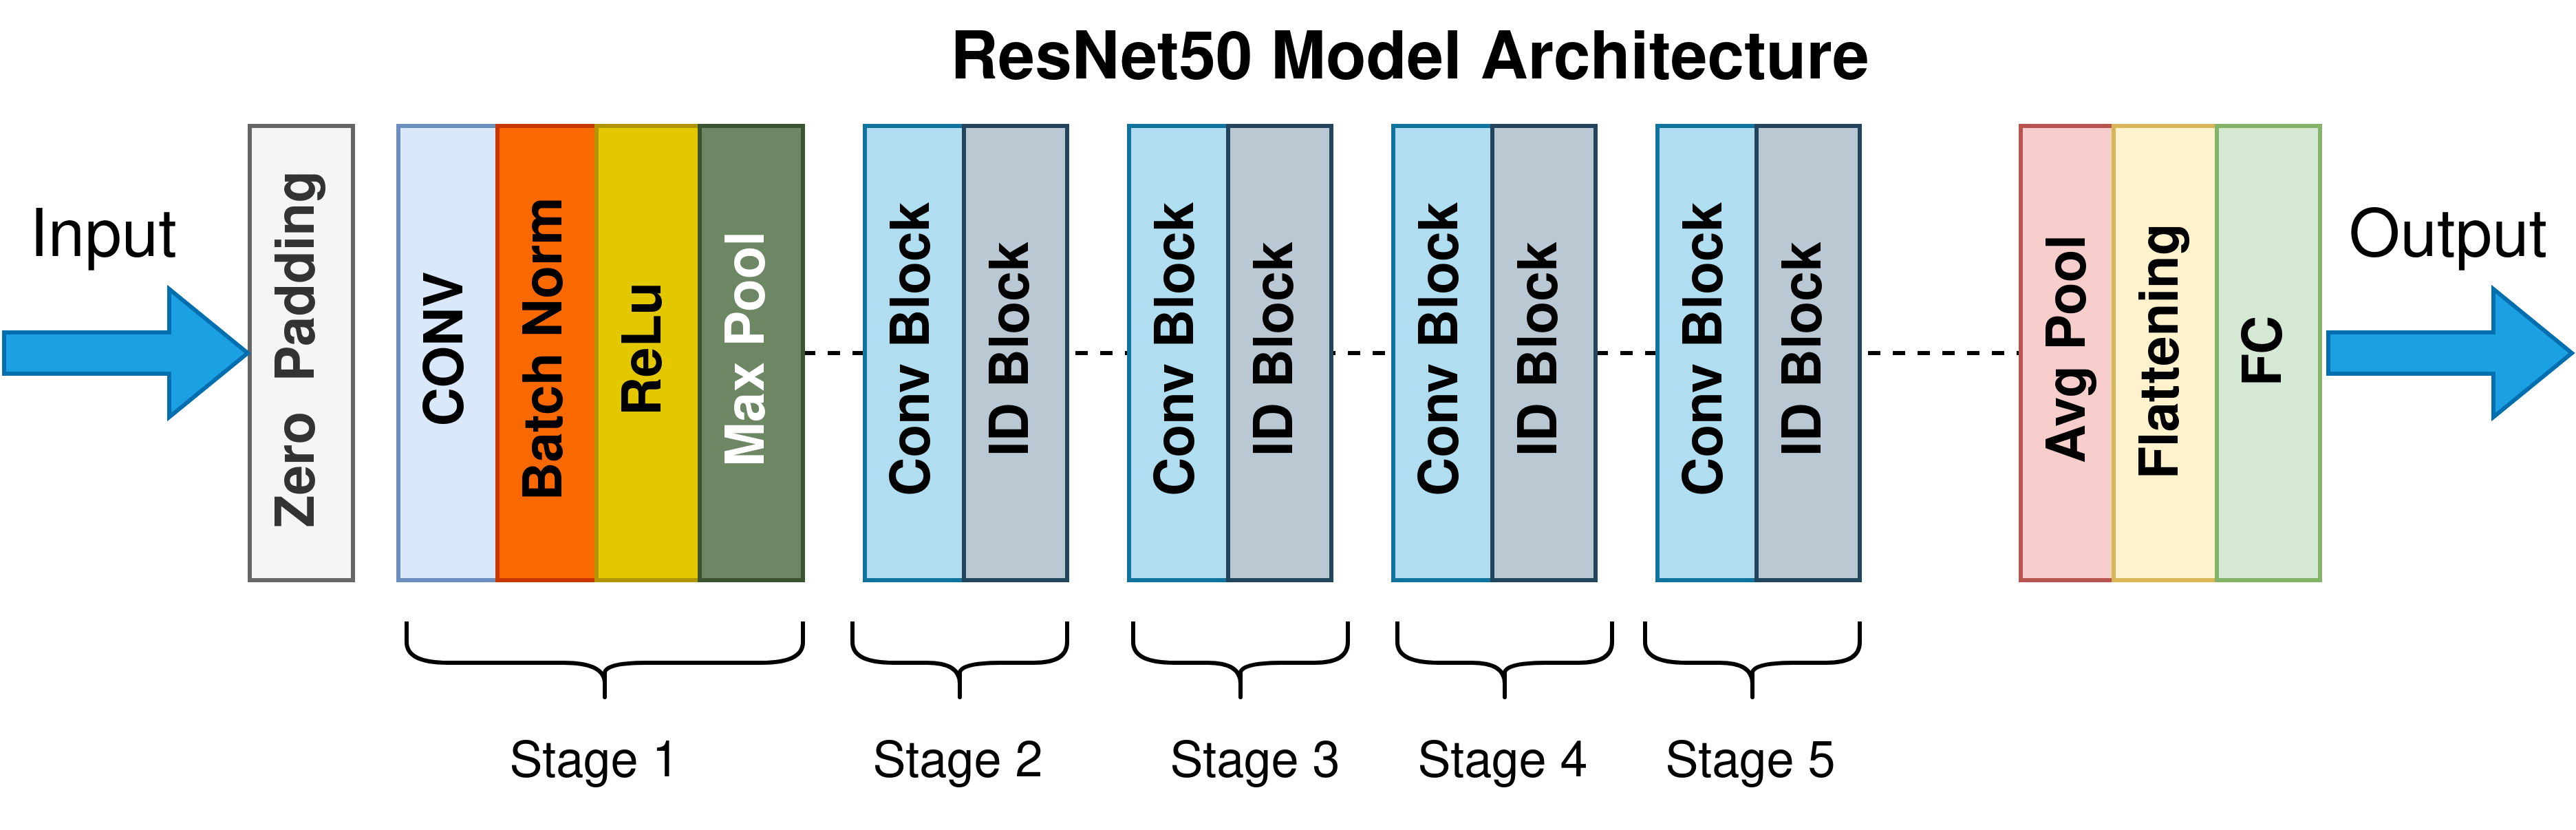!

In [ ]:
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
resnet50_base.trainable = False

resnet50_model = Sequential([
    resnet50_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(38, activation='softmax')
])

#compiling:
resnet50_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#5. Architecture diagrams + summaries

In [ ]:
# Print text summary
#1. CNN
print("\n--- Custom CNN Architecture ---")
compact_cnn.summary()
print(f"\nTotal parameters: {compact_cnn.count_params():,}")


--- Custom CNN Architecture ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │       627,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 38)             │         3,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641,282 (2.45 MB)

 Trainable params: 641,282 (2.45 MB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 641,282


In [ ]:
#2. MobileNetV3
print("\n--- MobileNetV3-Small Architecture ---")
mobilenet_model.summary()
print(f"\nTotal parameters: {mobilenet_model.count_params():,}")


--- MobileNetV3-Small Architecture ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 38)             │     1,072,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,011,670 (7.67 MB)

 Trainable params: 1,072,550 (4.09 MB)

 Non-trainable params: 939,120 (3.58 MB)


Total parameters: 2,011,670


In [ ]:
#3. ResNet50
print("\n--- ResNet50 Architecture ---")
resnet50_model.summary()
print(f"\nTotal parameters: {resnet50_model.count_params():,}")


--- ResNet50 Architecture ---


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,854,886 (91.00 MB)

 Trainable params: 267,174 (1.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Total parameters: 23,854,886


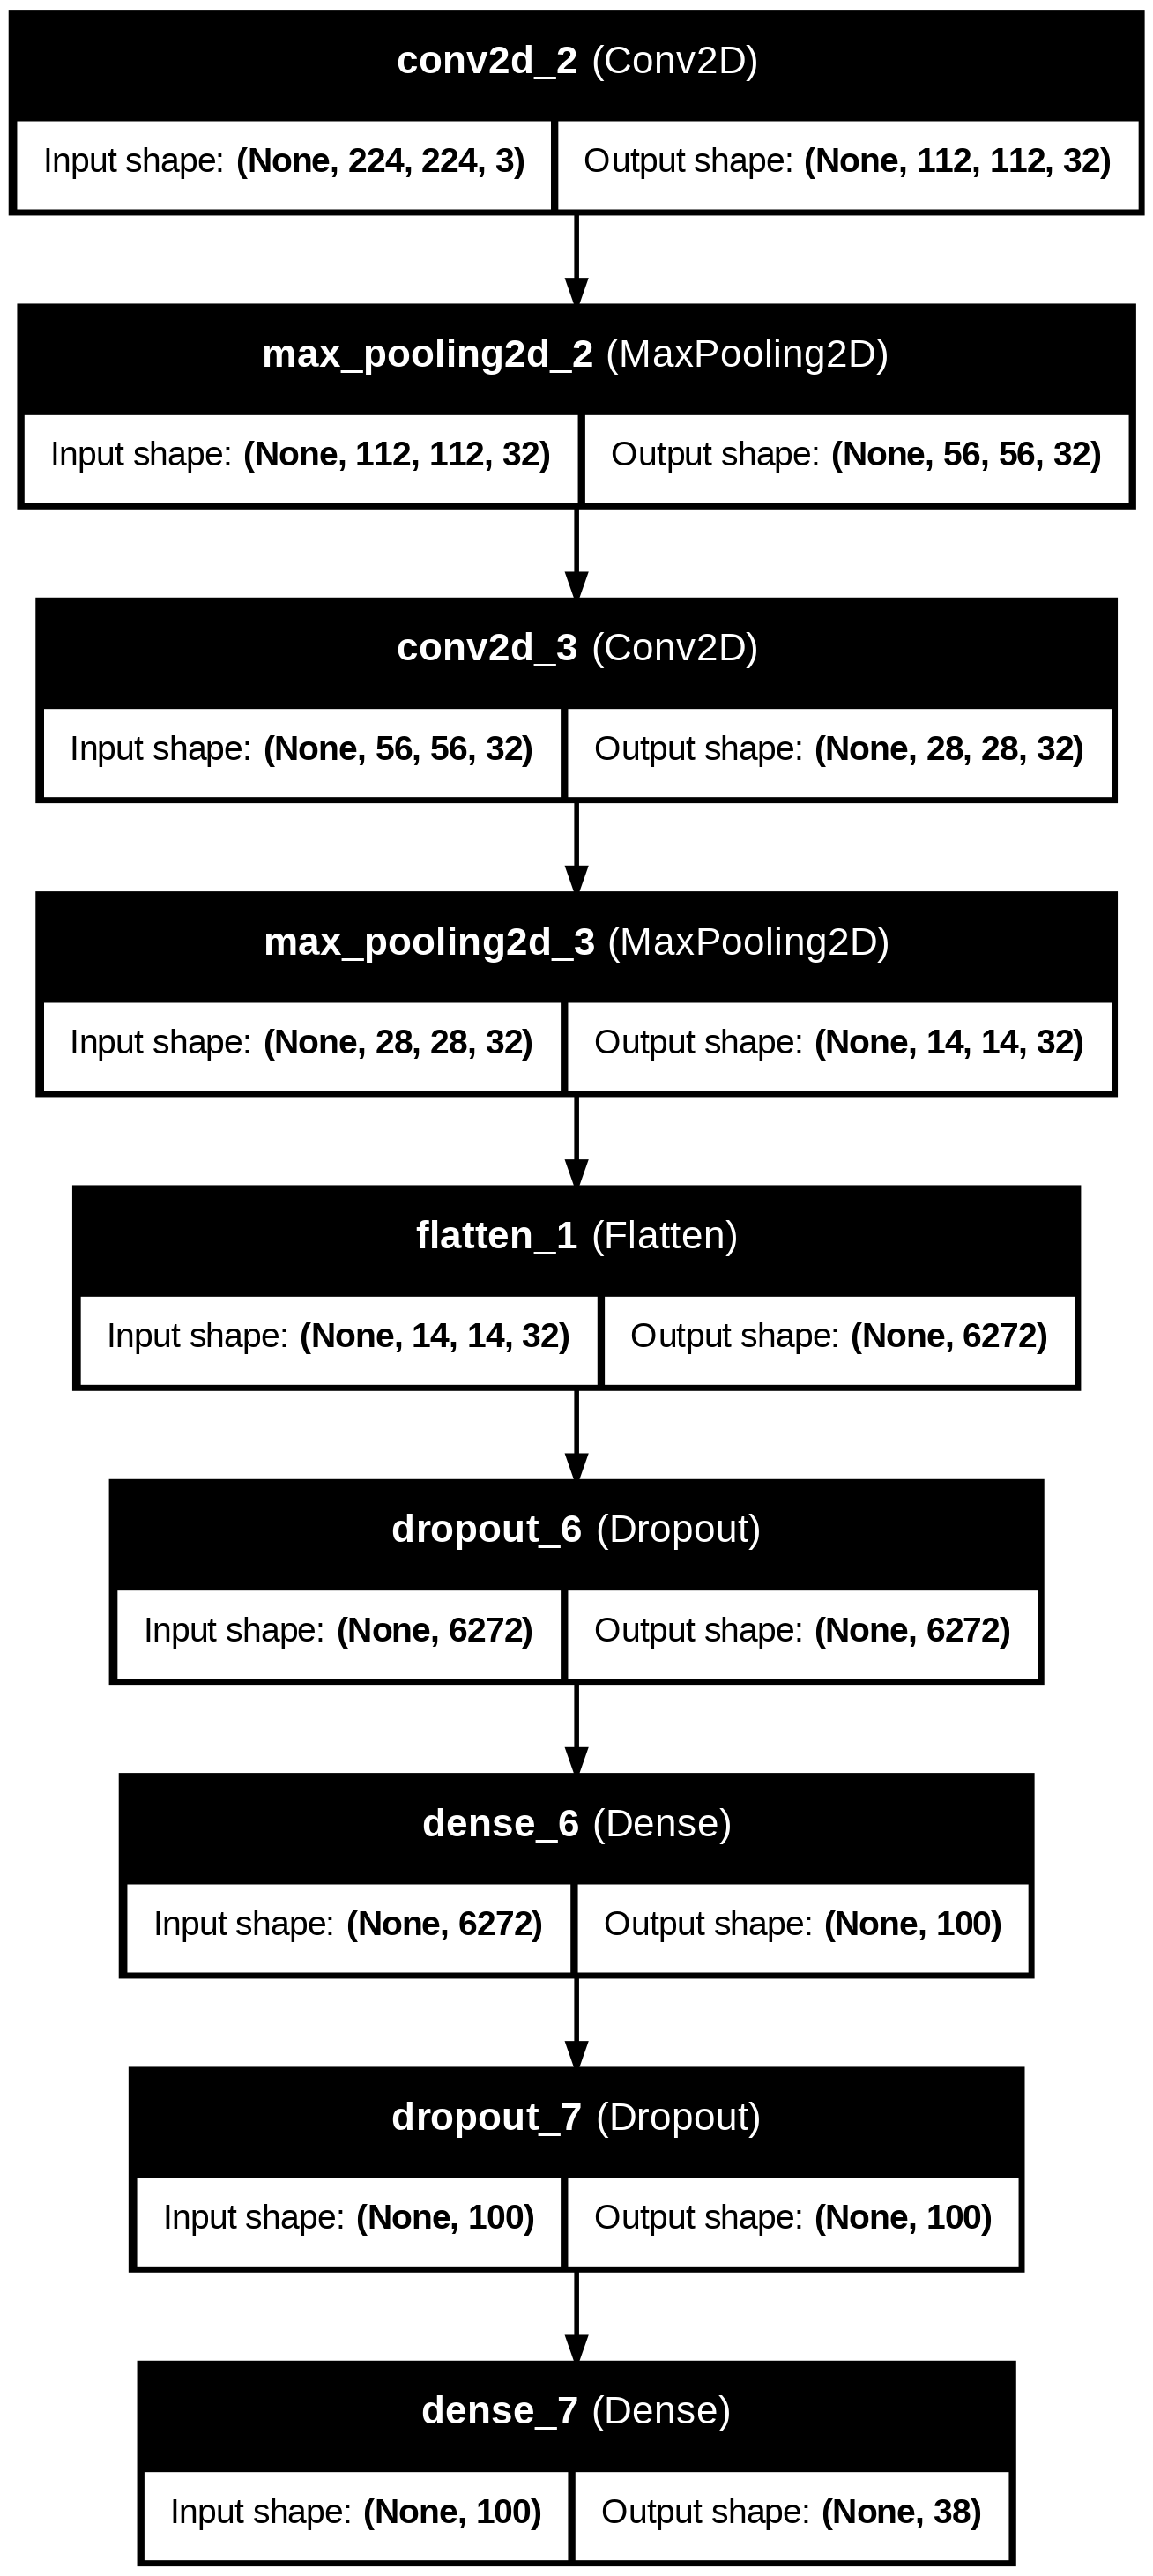

In [ ]:
# Save architecture diagrams as PNG
plot_model(compact_cnn, to_file="cnn_arch.png", show_shapes=True, show_layer_names=True)


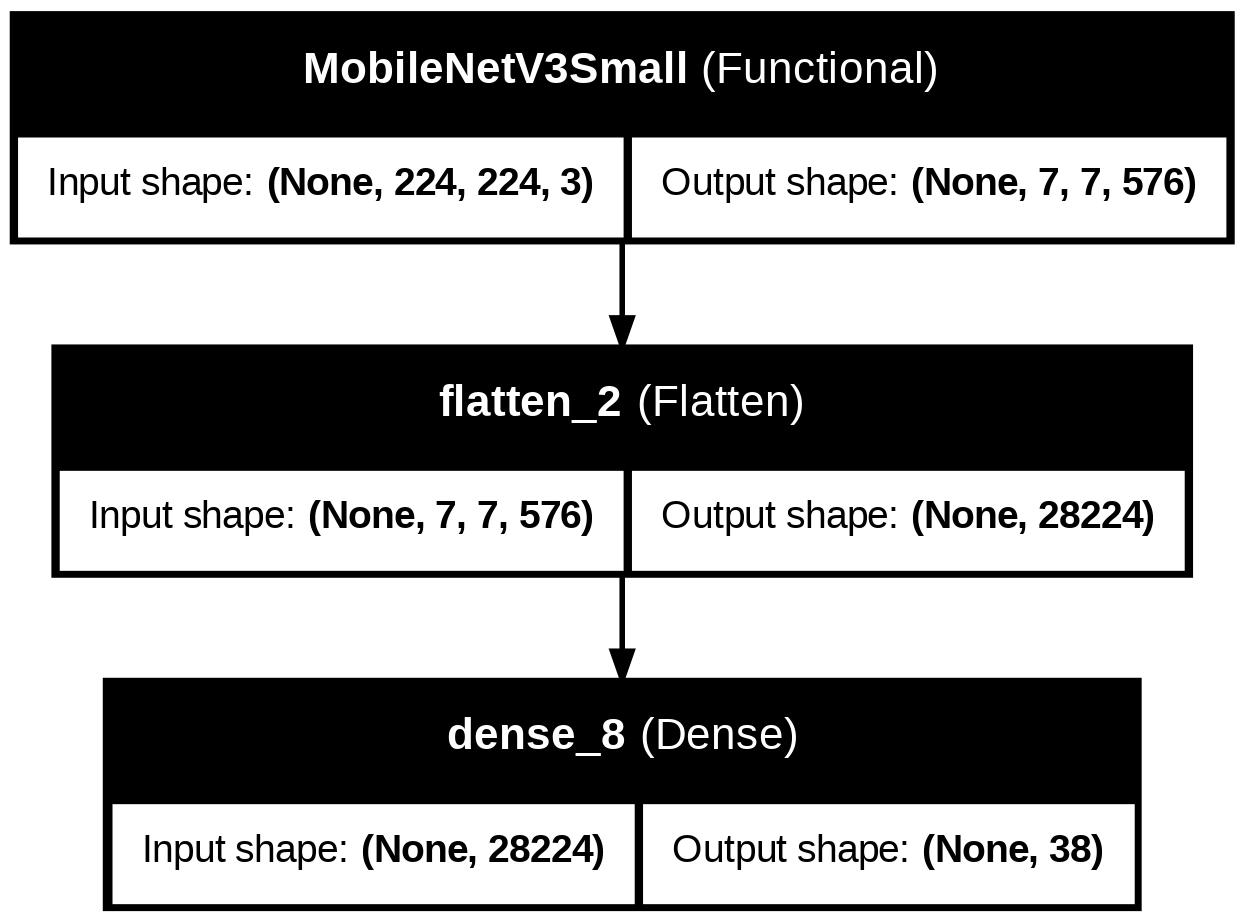

In [ ]:
#mobile
plot_model(mobilenet_model, to_file="mobilenet_v3_arch.png", show_shapes=True, show_layer_names=True)


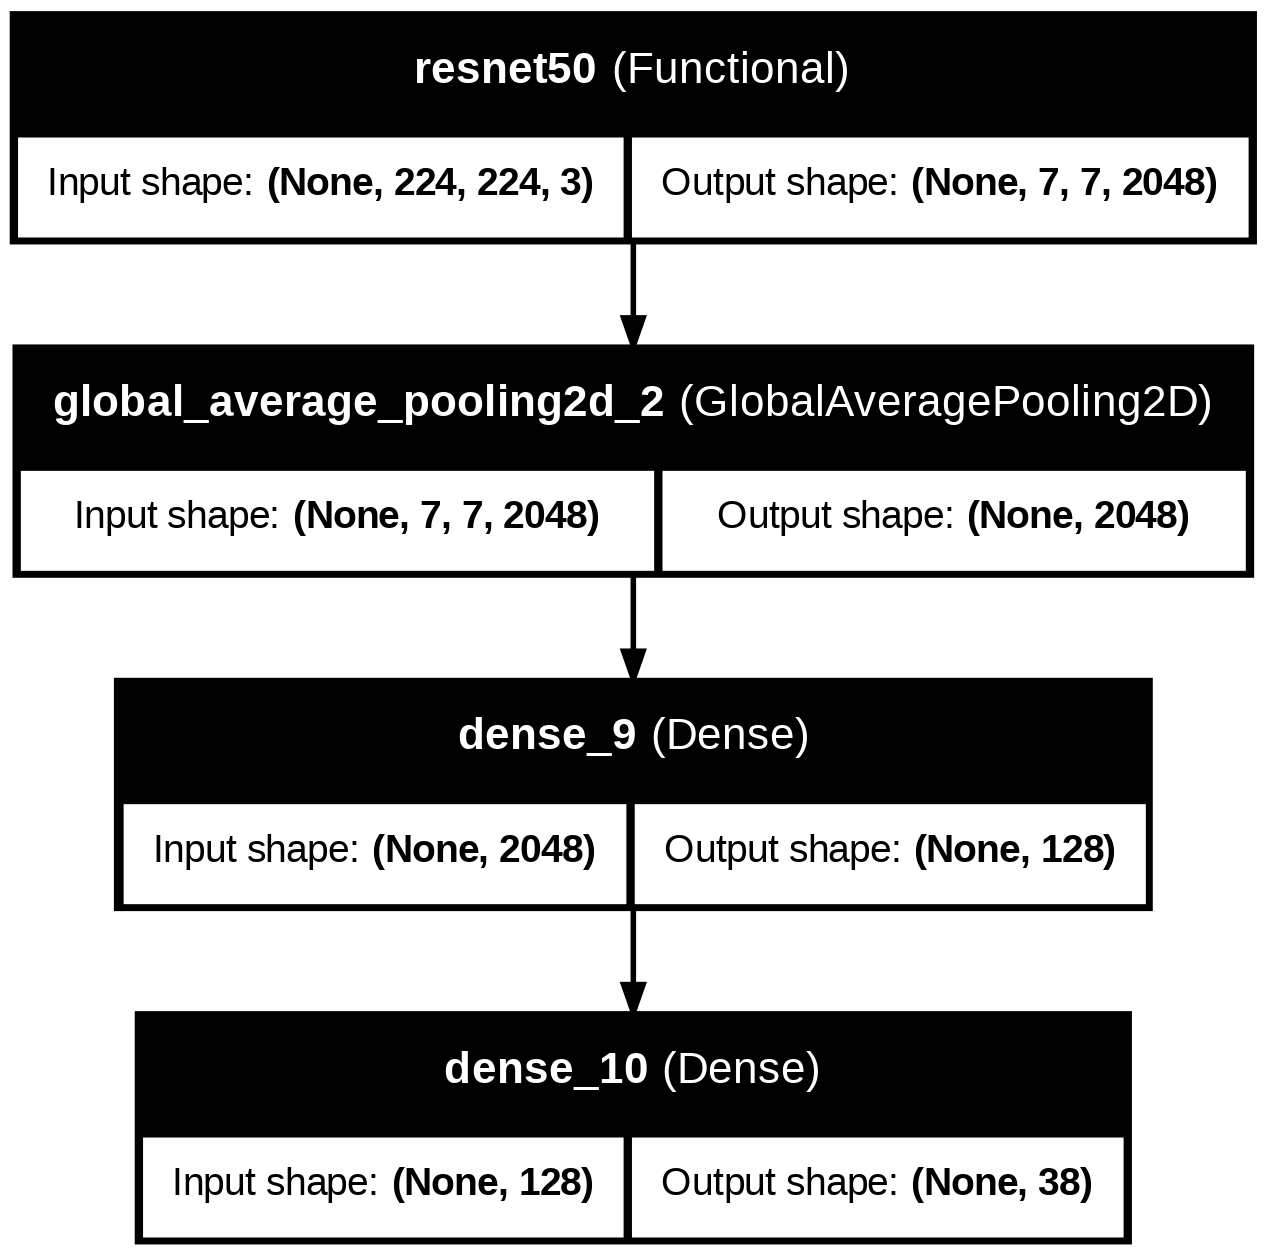

In [ ]:
#resnet
plot_model(resnet50_model, to_file="resnet50_arch.png", show_shapes=True, show_layer_names=True)

# 6. Callbacks & Saving Best Model

### **We will add 3 Very Important Callbacks for our model**

* **EarlyStopping:** This callback stops the training process **`if the validation loss doesn't improve for a certain number of epochs.`**
* **ReduceLROnPlateu:** This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the **`learning rate is reduced`**.
* **ModelCheckpoint:** This callback saves the model weights after **every epoch** if the validation loss improves.

All of them **`prevent Overfitting`** and save the best model according to the validation loss.


In [ ]:
#cnn and save the best model in a .keras file
callbacks_cnn = [
    ModelCheckpoint('best_cnn.keras', save_best_only=True, monitor='val_loss',mode="min",verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
]

#mobile
callbacks_mobile = [
    ModelCheckpoint('best_mobilev3.keras', save_best_only=True, monitor='val_loss',mode="min",verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
]
#resnet
callbacks_resnet = [
    ModelCheckpoint('best_resnet50.keras', save_best_only=True, monitor='val_loss',mode="min",verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
]

#7. Training

In [ ]:
# Trains the models for up to 20 epochs and applies all defined callbacks for best performance and generalization
epochs = 20
results = {}

# Train Custom CNN
print("Training Custom CNN")
print("-"*80)
start_time = time.time()
history_cnn = compact_cnn.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=callbacks_cnn,
    verbose=1
)
training_time_cnn = time.time() - start_time
results['Custom CNN'] = {'history': history_cnn, 'training_time': training_time_cnn}



Training Custom CNN
--------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1738/1739 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3474 - loss: 2.4448
Epoch 1: val_loss improved from inf to 1.01286, saving model to best_cnn.keras
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 69s 34ms/step - accuracy: 0.3475 - loss: 2.4442 - val_accuracy: 0.7019 - val_loss: 1.0129 - learning_rate: 0.0010
Epoch 2/20
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6071 - loss: 1.3144
Epoch 2: val_loss improved from 1.01286 to 0.72492, saving model to best_cnn.keras
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 50s 29ms/step - accuracy: 0.6071 - loss: 1.3144 - val_accuracy: 0.7870 - val_loss: 0.7249 - learning_rate: 0.0010
Epoch 3/20
1737/1739 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6673 - loss: 1.0956
Epoch 3: val_loss improved from 0.72492 to 0.63903, saving model to best_cnn.keras
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 49s 28ms/step - accuracy: 0.6673 - loss: 1.0955 - val_accuracy: 0.8102 - val_loss: 0.6390 - learning_rate: 0.0010
Epoch 4/20
1738/1739 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/ste

In [ ]:
# Train MobileNetV3
print("Training MobileNetV3-Small (Transfer Learning)")
print("-"*80)
start_time = time.time()
history_mobile = mobilenet_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=callbacks_mobile,
    verbose=1
)
training_time_mobile = time.time() - start_time
results['MobileNetV3'] = {'history': history_mobile, 'training_time': training_time_mobile}


Training MobileNetV3-Small (Transfer Learning)
--------------------------------------------------------------------------------
Epoch 1/20
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1983 - loss: 3.9581
Epoch 1: val_loss improved from inf to 2.87525, saving model to best_mobilev3.keras
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - accuracy: 0.1984 - loss: 3.9578 - val_accuracy: 0.3644 - val_loss: 2.8752 - learning_rate: 0.0010
Epoch 2/20
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3564 - loss: 2.8282
Epoch 2: val_loss improved from 2.87525 to 2.56893, saving model to best_mobilev3.keras
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 56s 32ms/step - accuracy: 0.3564 - loss: 2.8282 - val_accuracy: 0.4255 - val_loss: 2.5689 - learning_rate: 0.0010
Epoch 3/20
1738/1739 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4225 - loss: 2.5657
Epoch 3: val_loss improved from 2.56893 to 2.20238, saving model to best_mobilev3.keras
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 54s 31ms/step - accuracy

In [ ]:
# Train ResNet50
print("\n" + "-"*80)
print("Training ResNet50 (Transfer Learning)")
print("-"*80)
start_time = time.time()
history_resnet = resnet50_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=callbacks_resnet,
    verbose=1
)
training_time_resnet = time.time() - start_time
results['ResNet50'] = {'history': history_resnet, 'training_time': training_time_resnet}


--------------------------------------------------------------------------------
Training ResNet50 (Transfer Learning)
--------------------------------------------------------------------------------
Epoch 1/20
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.1725 - loss: 3.1669
Epoch 1: val_loss improved from inf to 2.60024, saving model to best_resnet50.keras
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 131s 68ms/step - accuracy: 0.1726 - loss: 3.1668 - val_accuracy: 0.3190 - val_loss: 2.6002 - learning_rate: 0.0010
Epoch 2/20
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3167 - loss: 2.5083
Epoch 2: val_loss improved from 2.60024 to 2.23836, saving model to best_resnet50.keras
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 106s 61ms/step - accuracy: 0.3168 - loss: 2.5083 - val_accuracy: 0.3713 - val_loss: 2.2384 - learning_rate: 0.0010
Epoch 3/20
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3873 - loss: 2.1909
Epoch 3: val_loss improved from 2.23836 to 2.03428, saving model to 

#8. Reload the saved models

In [ ]:
# Load the models back
cnn_model_loaded = load_model("best_cnn.keras")
mobilenet_model_loaded = load_model("best_mobilev3.keras")
resnet_model_loaded = load_model("best_resnet50.keras")

models_dict = {
    'Custom CNN': cnn_model_loaded,
    'MobileNetV3': mobilenet_model_loaded,
    'ResNet50': resnet_model_loaded
}

#9. Evaluation

In [ ]:
#Inference Time Measurement
print("Measuring Inference Time")
print("="*80)
def measure_inference_time(model, num_iterations=20):
    # Create dummy input
    dummy_input = np.random.rand(1, 224, 224, 3).astype(np.float32)

    _ = model.predict(dummy_input, verbose=0)

    times = []
    for _ in range(num_iterations):
        start = time.time()
        _ = model.predict(dummy_input, verbose=0)
        times.append(time.time() - start)

    avg_time = np.mean(times) # Convert to milliseconds

    return avg_time
##
inference_results = {}

print("\nMeasuring inference time (20 iterations per model)...")
for model_name, model in models_dict.items():
    print(f"\n{model_name}:")
    avg_time= measure_inference_time(model)
    inference_results[model_name] = {'avg_time': avg_time}
    print(f"  Average inference time: {avg_time:.2f} ms")


Measuring Inference Time

Measuring inference time (20 iterations per model)...

Custom CNN:
  Average inference time: 0.07 ms

MobileNetV3:
  Average inference time: 0.07 ms

ResNet50:
  Average inference time: 0.08 ms


In [ ]:
#Evaluation on Train and Validation Sets
print(" Model Evaluation on Train and Validation Sets")
print("="*80)
evaluation_results = {}

for model_name, model in models_dict.items():
    print(f"\n{'-'*80}")
    print(f"Evaluating {model_name}")
    print(f"{'-'*80}")

    # Train evaluation
    print("Evaluating on Training Set...")
    train_loss, train_acc = model.evaluate(train_dataset, verbose=1)

    # Validation evaluation
    print("Evaluating on Validation Set...")
    val_loss, val_acc = model.evaluate(validation_dataset, verbose=1)

    # Get predictions for validation set
    y_pred_prob = model.predict(validation_dataset, verbose=1)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = validation_dataset.classes

    # Calculate metrics
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Calculate per-class accuracy
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    # Store results
    evaluation_results[model_name] = {
        'train_accuracy': train_acc,
        'train_loss': train_loss,
        'val_accuracy': val_acc,
        'val_loss': val_loss,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob,
        'confusion_matrix': cm,
        'per_class_accuracy': per_class_acc,
        'params': model.count_params(),
        'inference_time': inference_results[model_name]['avg_time']
    }

    print(f"\nResults:")
    print(f"  Train Accuracy: {train_acc*100:.2f}%")
    print(f"  Val Accuracy: {val_acc*100:.2f}%")
    print(f"  F1-Score: {f1:.4f}")


 Model Evaluation on Train and Validation Sets

--------------------------------------------------------------------------------
Evaluating Custom CNN
--------------------------------------------------------------------------------
Evaluating on Training Set...
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.9587 - loss: 0.1479
Evaluating on Validation Set...
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8861 - loss: 0.3439
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step

Results:
  Train Accuracy: 95.87%
  Val Accuracy: 90.60%
  F1-Score: 0.9047

--------------------------------------------------------------------------------
Evaluating MobileNetV3
--------------------------------------------------------------------------------
Evaluating on Training Set...
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.6462 - loss: 1.3025
Evaluating on Validation Set...
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5951 - loss: 1.5369
108/108 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
#MODELS COMPARISON TABLE
print("MODELS COMPARISON TABLE")
print("="*80)
comparison_data = []
model_names = ['Custom CNN', 'MobileNetV3', 'ResNet50']

for model_name in model_names:
    result = evaluation_results[model_name]
    training_result = results[model_name]

    comparison_data.append({
        '---Model---': model_name,
        'Parameters': f"{result['params']/1e6:.2f}M",
        'Train Acc': f"{result['train_accuracy']*100:.2f}%",
        'Val Acc': f"{result['val_accuracy']*100:.2f}%",
        'F1-Score': f"{result['f1_score']:.4f}",
        'Inference': f"{result['inference_time']:.2f}s",
        'Train Time': f"{training_result['training_time']/60:.1f}min"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

MODELS COMPARISON TABLE

       Model Parameters Train Acc Val Acc F1-Score Inference Train Time
 Custom CNN      0.64M    95.87%  90.60%   0.9047     0.07s    18.4min
MobileNetV3      2.01M    64.46%  62.64%   0.6186     0.07s    18.8min
   ResNet50     23.85M    61.80%  61.99%   0.6028     0.08s    36.2min


The combact CNN has performed the best.

##10.  Visualizations

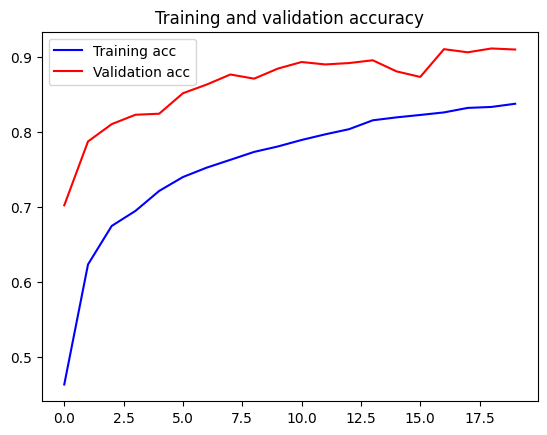

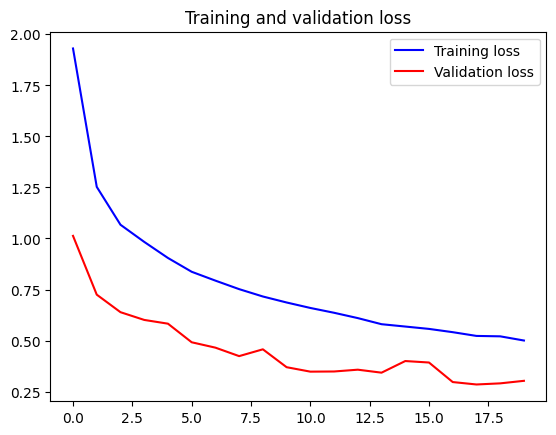

In [ ]:
#plot the loss and accuracy curves for CNN
history = results['Custom CNN']['history']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Generating Confusion Matrix for Custom CNN...


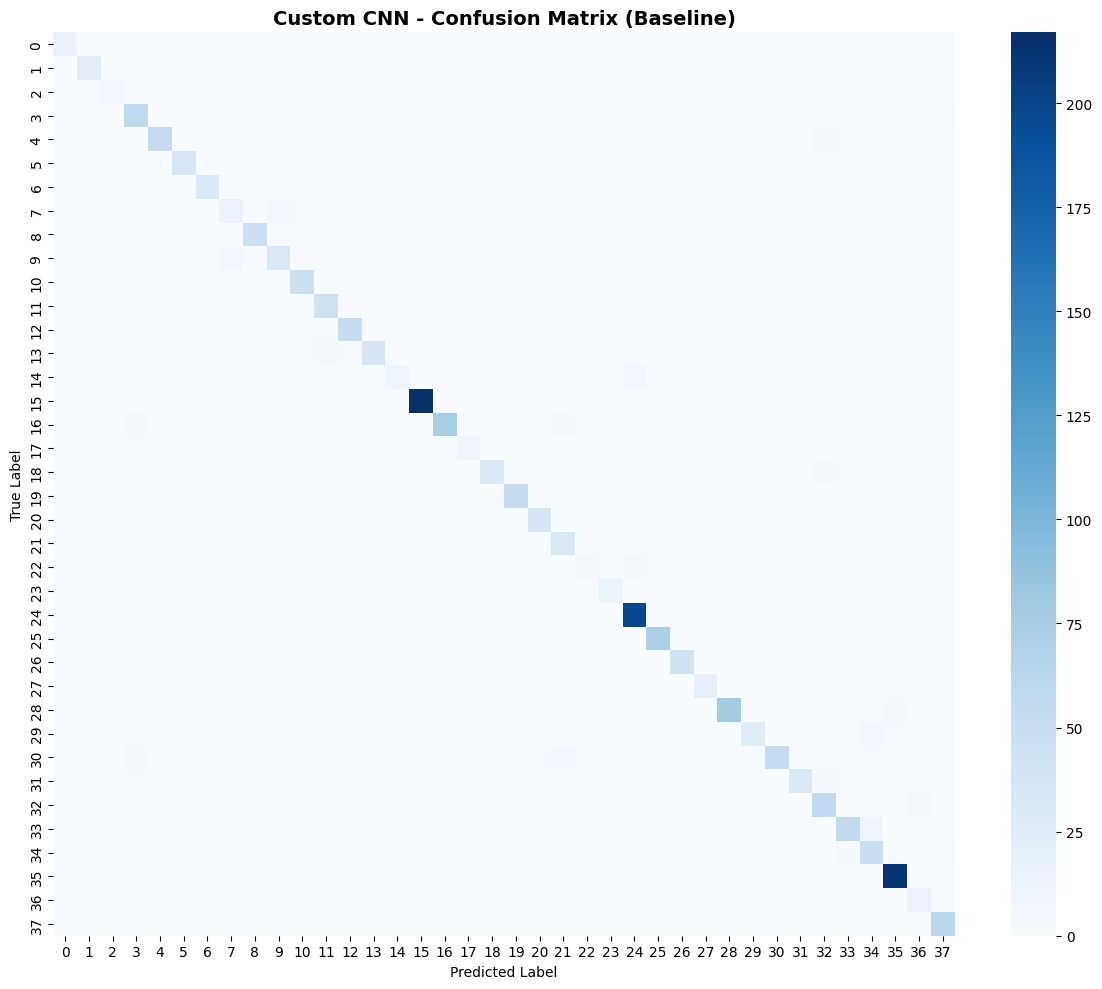

In [ ]:
# Confusion Matrix for CNN
print("\nGenerating Confusion Matrix for Custom CNN...")
cm = evaluation_results['Custom CNN']['confusion_matrix']
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d', cbar=True)
plt.title('Custom CNN - Confusion Matrix (Baseline)', fontweight='bold', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

GENERATING ROC CURVE FOR CUSTOM CNN


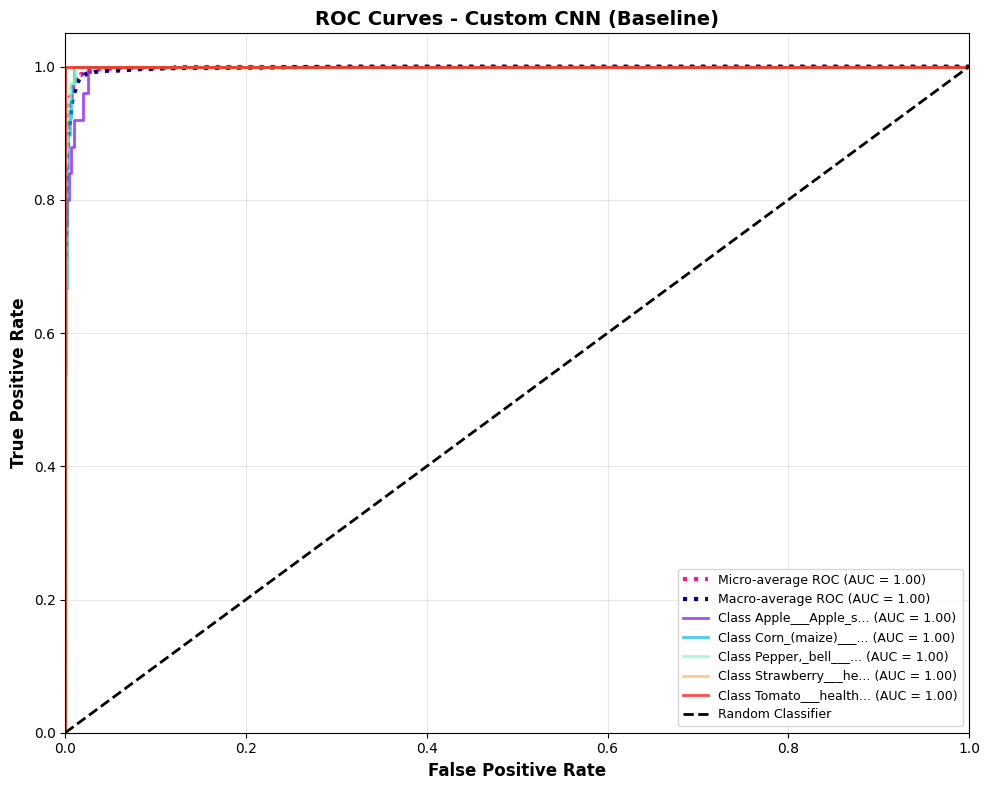

In [ ]:
#plot roc_curve for CNN
print("GENERATING ROC CURVE FOR CUSTOM CNN")
print("="*80)

# Binarize the output for multi-class ROC
y_true_bin = label_binarize(evaluation_results['Custom CNN']['y_true'],
                             classes=range(num_classes))
y_pred_prob = evaluation_results['Custom CNN']['y_pred_prob']

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=3)
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=3)

# Plot some individual class ROC curves (sample 5 classes)
colors = plt.cm.rainbow(np.linspace(0, 1, min(5, num_classes)))
sample_classes = np.linspace(0, num_classes-1, min(5, num_classes), dtype=int)

for i, color in zip(sample_classes, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, alpha=0.7,
             label=f'Class {class_names[i][:15]}... (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold', fontsize=12)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=12)
plt.title('ROC Curves - Custom CNN (Baseline)', fontweight='bold', fontsize=14)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Data Augmentation on custom CNN
Test if augmentation improves the best-performing model

In [ ]:
# Create augmented data generator
train_datagen_aug = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,              # Simulate different viewing angles
    width_shift_range=0.2,          # Simulate drone position variance
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,                # Simulate altitude changes
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],    # Simulate lighting conditions
    fill_mode='nearest',
    validation_split=0.20
)

# Load augmented training data
train_dataset_aug = train_datagen_aug.flow_from_directory(
    dataset_train,
    shuffle=True,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    subset='training',
    seed=123,
)

validation_dataset_aug = train_datagen_aug.flow_from_directory(
    dataset_val,
    shuffle=False,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    subset='validation',
    seed=123,
)

print(f"\nAugmented Training samples: {train_dataset_aug.samples}")
print(f"Augmented Validation samples: {validation_dataset_aug.samples}")

Found 34771 images belonging to 38 classes.
Found 2160 images belonging to 38 classes.

Augmented Training samples: 34771
Augmented Validation samples: 2160



Visualizing augmented images...


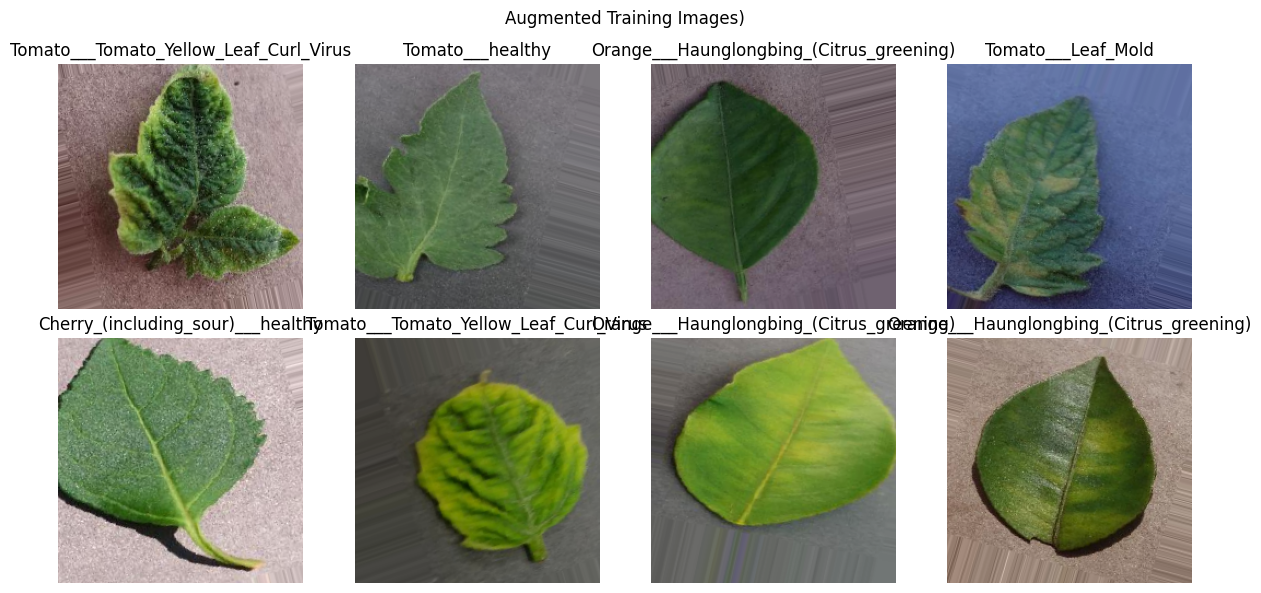

In [ ]:
# Visualize augmented images
print("\nVisualizing augmented images...")
images_aug, labels_aug = next(train_dataset_aug)
plt.figure(figsize=(12, 6))
plt.suptitle('Augmented Training Images)')
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images_aug[i])
    plt.title(class_names[np.argmax(labels_aug[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# Callbacks for augmented training
callbacks_cnn_aug = [
    ModelCheckpoint('best_cnn_augmented.keras', save_best_only=True, monitor='val_loss', mode="min", verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]
# Train augmented model
print("\nTraining Custom CNN with Data Augmentation...")
print("-"*80)
start_time_aug = time.time()
history_cnn_aug = compact_cnn.fit(
    train_dataset_aug,
    validation_data=validation_dataset_aug,
    epochs=20,
    callbacks=callbacks_cnn_aug,
    verbose=1
)
training_time_aug = time.time() - start_time_aug

print(f"\nAugmented CNN Training completed in {training_time_aug/60:.1f} minutes")

# Load best augmented model
cnn_aug_loaded = load_model("best_cnn_augmented.keras")


Training Custom CNN with Data Augmentation...
--------------------------------------------------------------------------------
Epoch 1/20
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.5796 - loss: 1.5062

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.76102, saving model to best_cnn_augmented.keras
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 514s 296ms/step - accuracy: 0.5796 - loss: 1.5062 - val_accuracy: 0.7847 - val_loss: 0.7610 - learning_rate: 0.0010
Epoch 2/20
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.6562 - loss: 1.1709
Epoch 2: val_loss improved from 0.76102 to 0.72557, saving model to best_cnn_augmented.keras
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 505s 290ms/step - accuracy: 0.6562 - loss: 1.1709 - val_accuracy: 0.7843 - val_loss: 0.7256 - learning_rate: 0.0010
Epoch 3/20
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.6811 - loss: 1.0759
Epoch 3: val_loss improved from 0.72557 to 0.63997, saving model to best_cnn_augmented.keras
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 468s 269ms/step - accuracy: 0.6811 - loss: 1.0759 - val_accuracy: 0.8023 - val_loss: 0.6400 - learning_rate: 0.0010
Epoch 4/20
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.6915 - loss: 1.0261
Epoch 4: val_

In [ ]:
# Evaluate augmented model
print("\nEvaluating Augmented Custom CNN on validation_dataset...")
test_loss_aug, test_acc_aug = cnn_aug_loaded.evaluate(validation_dataset, verbose=0)
y_pred_prob_aug = cnn_aug_loaded.predict(validation_dataset, verbose=0)
y_pred_aug = np.argmax(y_pred_prob_aug, axis=1)
y_true_aug = validation_dataset.classes

precision_aug = precision_score(y_true_aug, y_pred_aug, average='weighted', zero_division=0)
recall_aug = recall_score(y_true_aug, y_pred_aug, average='weighted', zero_division=0)
f1_aug = f1_score(y_true_aug, y_pred_aug, average='weighted', zero_division=0)
cm_aug = confusion_matrix(y_true_aug, y_pred_aug)

# Measure inference time for augmented model
avg_time_aug= measure_inference_time(cnn_aug_loaded)

print(f"\nAugmented CNN Results:")
print(f"  Test Accuracy: {test_acc_aug*100:.2f}%")
print(f"  Precision: {precision_aug:.4f}")
print(f"  Recall: {recall_aug:.4f}")
print(f"  F1-Score: {f1_aug:.4f}")
print(f"  Inference Time: {avg_time_aug:.4f}s")


Evaluating Augmented Custom CNN on validation_dataset...

Augmented CNN Results:
  Test Accuracy: 82.92%
  Precision: 0.8541
  Recall: 0.8292
  F1-Score: 0.8292
  Inference Time: 0.0610s


###  Key Observations
- The **custom lightweight CNN** achieved **90.60% validation accuracy** with only **0.64M parameters**, representing a **37× reduction** compared to ResNet50.  
- The custom CNN’s **inference time (0.07s per image)** makes it suitable for **real-time drone deployment**.  
- **Data augmentation** reduced test accuracy by ~8%, but performance was **still higher than other models**.  
- **ResNet50**, while powerful, required significantly more parameters and computational resources, limiting its practicality for edge deployment.  
- **MobileNetV3-Small** provided efficiency but did not outperform the custom CNN in this setting.  
- Training curves showed the **loss was still decreasing at epoch 20**, indicating the models had not fully converged.  

---

### Recommendations
- **Extend training** with more epochs on **high-capacity GPUs** to achieve better convergence.  
- Apply **further data preprocessing**, including advanced augmentation and **segmentation techniques**.  
- **Evaluate on diverse datasets** such as **PlantDoc** to test generalization across domains.  
- Consider **fine-tuning pretrained models** (e.g., unfreezing top layers) for potential accuracy gains.  
- Measure both **training time** and **inference time** to balance model accuracy with deployment feasibility.  
- Focus on **lightweight CNN architectures** for drone-based precision agriculture where **low latency and efficiency** are critical.  
